In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


# module 
from dataset.basedataset import ACDCDataset
from dataset.utils import RandomGenerator
from utils.params import params

In [2]:
args = params() 

#### 1. UNet2d

In [3]:
# Build again UNet backbone 
class ConvBlock(nn.Module): 
    """
    Two convolution block with batchnorm and leakyrelu 
    Dont change the output size  
    """
    def __init__(self, in_channel, out_channel, dropout_p): 
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding= 1), # Dont decrease ??
            nn.BatchNorm2d(out_channel), 
            nn.LeakyReLU(), 
            nn.Dropout(dropout_p), 

            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channel), 
            nn.LeakyReLU()
        ) 

    def forward(self, x): 
        return self.conv(x) 

class DownBlock(nn.Module): 
    """
    Downsample follow by ConvBlock
    """
    def __init__(self, in_channel, out_channel, dropout_p): 
        super(DownBlock, self).__init__() 

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size= 2), 
            ConvBlock(in_channel, out_channel, dropout_p)
        )

    def forward(self, x): 
        return self.maxpool_conv(x)
    

class UpBlock(nn.Module): # Check if have problem  
    def __init__(self, in_channel1, in_channel2, out_channel, dropout_p): 
        super(UpBlock, self).__init__() 

        self.convx1 = nn.Conv2d(in_channel1, in_channel2, kernel_size= 1) # WRD
        self.up = nn.Upsample(scale_factor= 2, mode= 'bilinear', align_corners= True)
        self.conv = ConvBlock(in_channel2 * 2, out_channel, dropout_p)
         
    def forward(self, x1, x2): 
        x1 = self.convx1(x1)
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim= 1)
        return self.conv(x)

class Encoder(nn.Module): 
    def __init__(self, params): 
        super(Encoder, self).__init__()
        self.params = params
        self.in_chs = self.params['in_chs']
        self.ft_chs = self.params['ft_chs']
        self.n_class = self.params['num_class']
        self.dropout = self.params['dropout']
        assert (len(self.ft_chs) == 5)

        self.conv = ConvBlock(self.in_chs, self.ft_chs[0], dropout_p= self.dropout[0])
        self.down1 = DownBlock(self.ft_chs[0], self.ft_chs[1], self.dropout[1])
        self.down2 = DownBlock(self.ft_chs[1], self.ft_chs[2], self.dropout[2])
        self.down3 = DownBlock(self.ft_chs[2], self.ft_chs[3], self.dropout[3])
        self.down4 = DownBlock(self.ft_chs[3], self.ft_chs[4], self.dropout[4])

    def forward(self, x): 
        x0 = self.conv(x) 
        x1 = self.down1(x0) 
        x2 = self.down2(x1) 
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        return [x0, x1, x2, x3, x4]


class Decoder(nn.Module): 
    def __init__(self, params): 
        super(Decoder, self).__init__() 
        self.params = params 
        self.in_chs = self.params['in_chs']
        self.ft_chs = self.params['ft_chs']
        self.n_class = self.params['num_class']
        assert (len(self.ft_chs) == 5)

        self.up1 = UpBlock(self.ft_chs[4], self.ft_chs[3], self.ft_chs[3], dropout_p= 0.0)
        self.up2 = UpBlock(self.ft_chs[3], self.ft_chs[2], self.ft_chs[2], dropout_p= 0.0)
        self.up3 = UpBlock(self.ft_chs[2], self.ft_chs[1], self.ft_chs[1], dropout_p= 0.0)
        self.up4 = UpBlock(self.ft_chs[1], self.ft_chs[0], self.ft_chs[0], dropout_p= 0.0)
        self.out_conv = nn.Conv2d(self.ft_chs[0], self.n_class, kernel_size= 3, padding= 1)


    def forward(self, feature): 
        x0 = feature[0] 
        x1 = feature[1] 
        x2 = feature[2] 
        x3 = feature[3]
        x4 = feature[4] 

        x = self.up1(x4, x3) 
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x_last = self.up4(x, x0)
        output = self.out_conv(x_last)
        return output, x_last
    
class UNet2d(nn.Module): 
    def __init__(self, in_chs, class_num=None, recon=False): 
        super(UNet2d, self).__init__() 
        self.recon = recon
        self.params = {
            'in_chs': in_chs, 
            'ft_chs': [16, 32, 64, 128, 256], 
            'dropout': [0.05, 0.1, 0.2, 0.3, 0.5], 
            'num_class': class_num if not recon else in_chs
        }

        self.encoder = Encoder(self.params) 
        self.decoder = Decoder(self.params)

        # ⬇️ final projection layer for reconstruction
        if recon:
            self.out_conv = nn.Conv2d(self.params['ft_chs'][0], in_chs, kernel_size=3, padding=1)
        else:
            self.out_conv = None

    def forward(self, x): 
        features = self.encoder(x) 
        x_out, x_last = self.decoder(features)

        if self.recon:
            return self.out_conv(x_last)  # Ensure output shape = input shape
        else:
            return x_out
        

#### 2. Patch 

In [4]:
def mask_image(img, mask_ratio = 0.5, block_size= 16): 
    batch_size, channel, H, W = img.shape 
    assert H % block_size == 0 and W % block_size == 0, 'Block size is not suitable'

    h_blocks = H // block_size 
    w_blocks = W // block_size 
    total_blockes = h_blocks * w_blocks
    num_mask = int(total_blockes * mask_ratio)

    mask = torch.ones((batch_size, 1, H, W), device= img.device)

    for i in range(batch_size): 
        patch_indices = [(h, w) for h in range(h_blocks) for w in range(w_blocks)]
        selected = torch.randperm(len(patch_indices))[: num_mask]

        for idx in selected: 
            h_idx, w_idx = patch_indices[idx]
            top = h_idx * block_size 
            left = w_idx * block_size
            mask[i, :, top : top + block_size, left : left + block_size] = 0 
    
    masked_img = img * mask 
    return masked_img, mask

#### 3.Training process

In [5]:
# Load dataset 
class MnistDataset(Dataset): 
    def __init__(self, transform= None): 
        self.transform = transform
        super(Dataset, self).__init__() 
        self.data = MNIST(root= '.', train= True, transform= transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()
        ]), download= True) 

    def __len__(self): 
        return len(self.data)

    def __getitem__(self, idx): 
        image,label = self.data[idx] # Content image, label
        if self.transform: 
            image = self.transform(image)
        return image, label 

In [6]:
def reconstruction_loss(X_rec, X_orig, mask, lam=0.1):
    """
    Compute full L_REC loss as in the SDCL paper:
    mask: 1 for visible, 0 for masked
    lam: lambda weight for visible region
    """
    loss_masked = ((1 - mask) * (X_rec - X_orig) ** 2).sum()
    loss_visible = (mask * (X_rec - X_orig) ** 2).sum()
    
    total_pixels = X_orig.numel()
    loss = (loss_masked + lam * loss_visible) / total_pixels
    return loss


Mode: reconstruct: 1902 samples in total
Epoch 1, Loss: 0.032934
Epoch 2, Loss: 0.020318
Epoch 3, Loss: 0.015032
Epoch 4, Loss: 0.012828
Epoch 5, Loss: 0.011975
Epoch 6, Loss: 0.011732
Epoch 7, Loss: 0.009678
Epoch 8, Loss: 0.010148
Epoch 9, Loss: 0.009574
Epoch 10, Loss: 0.008863


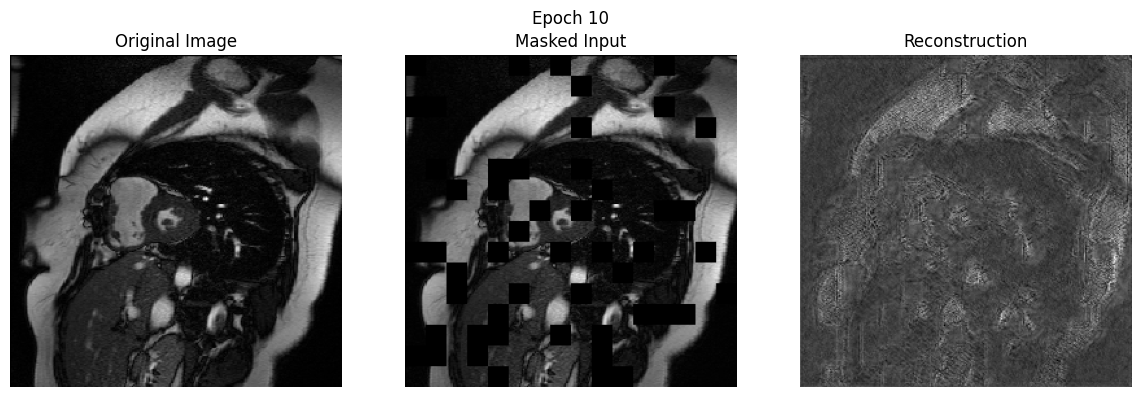

Epoch 11, Loss: 0.008059
Epoch 12, Loss: 0.008523
Epoch 13, Loss: 0.008284
Epoch 14, Loss: 0.007925
Epoch 15, Loss: 0.007745
Epoch 16, Loss: 0.007180
Epoch 17, Loss: 0.007439
Epoch 18, Loss: 0.007227
Epoch 19, Loss: 0.006694
Epoch 20, Loss: 0.006503


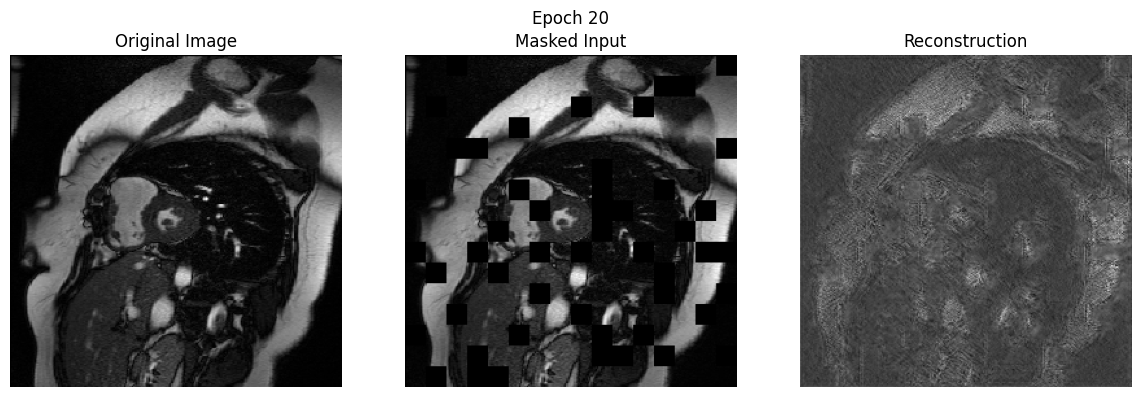

Epoch 21, Loss: 0.006971
Epoch 22, Loss: 0.006623
Epoch 23, Loss: 0.006288
Epoch 24, Loss: 0.006256
Epoch 25, Loss: 0.006711
Epoch 26, Loss: 0.006176
Epoch 27, Loss: 0.006164
Epoch 28, Loss: 0.005780
Epoch 29, Loss: 0.006487
Epoch 30, Loss: 0.006353


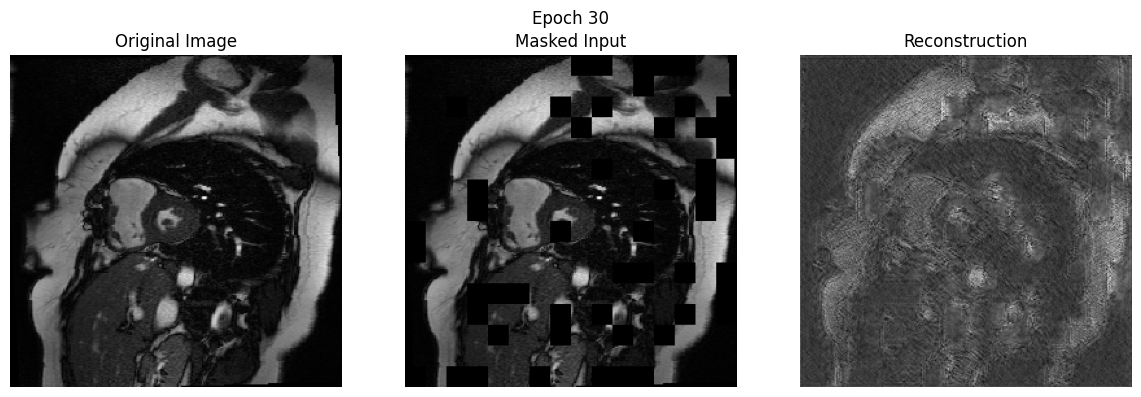

Epoch 31, Loss: 0.006088
Epoch 32, Loss: 0.005690
Epoch 33, Loss: 0.005701
Epoch 34, Loss: 0.005569
Epoch 35, Loss: 0.005641
Epoch 36, Loss: 0.005837
Epoch 37, Loss: 0.005285
Epoch 38, Loss: 0.005003
Epoch 39, Loss: 0.005179
Epoch 40, Loss: 0.005708


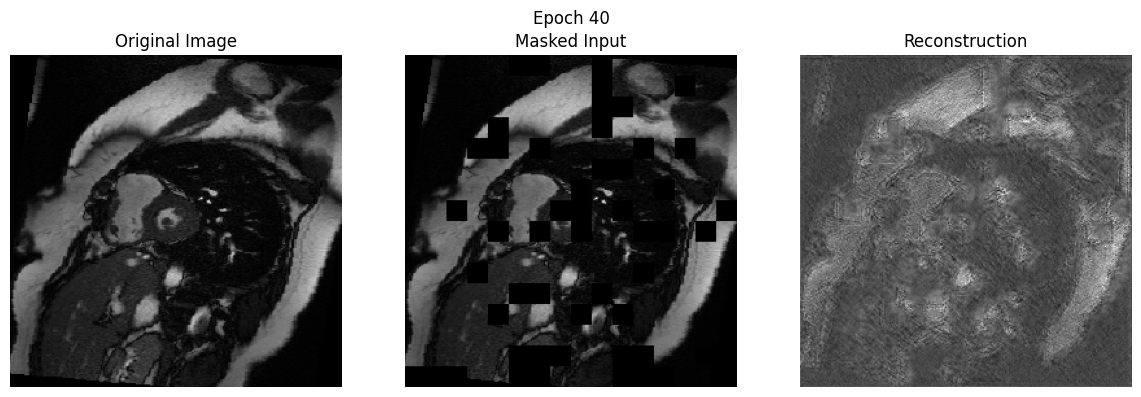

Epoch 41, Loss: 0.005015
Epoch 42, Loss: 0.005191
Epoch 43, Loss: 0.005421
Epoch 44, Loss: 0.004732
Epoch 45, Loss: 0.004917
Epoch 46, Loss: 0.005128
Epoch 47, Loss: 0.005047
Epoch 48, Loss: 0.004687
Epoch 49, Loss: 0.005050
Epoch 50, Loss: 0.004819


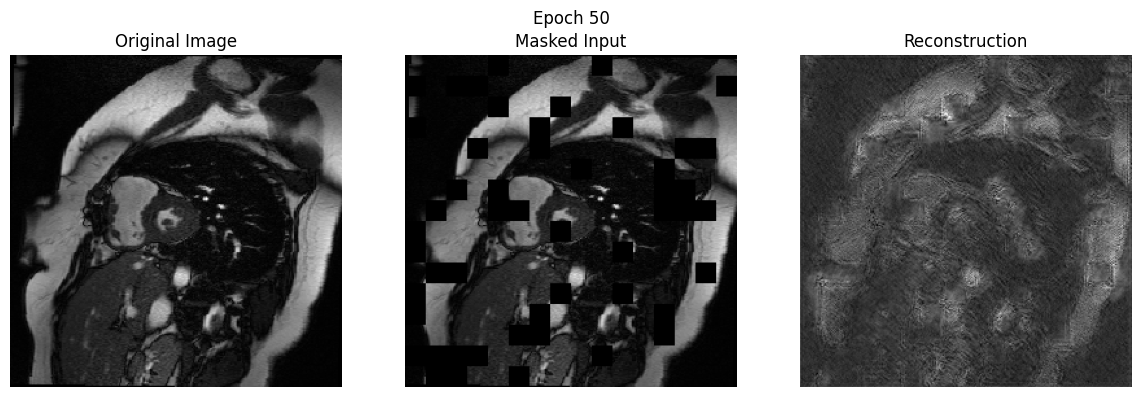

In [7]:
# Prepare data 
trainset = ACDCDataset(base_dir= args.root_dir, 
                       split= 'reconstruct', 
                       transform= transforms.Compose([RandomGenerator(args.patch_size)]))
trainloader = DataLoader(trainset, batch_size= 12, shuffle= False)

model = UNet2d(in_chs=1, recon=True).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
num_epochs = 50
mse_loss = nn.MSELoss()

for epoch in range(1, num_epochs + 1):
    for image, _ in trainloader: 
        image = image.cuda() 

        masked_img, mask = mask_image(image, block_size= 16, mask_ratio= 0.2)
        masked_img, mask = masked_img.cuda(), mask.cuda() 
        reconn = model(masked_img)

        # Compute masked loss only
        masked_pixels = (1 - mask)
        loss = reconstruction_loss(reconn, image, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    if epoch % 10 == 0:  
        img_disp = image[0].detach().cpu().squeeze().numpy()
        masked_disp = masked_img[0].detach().cpu().squeeze().numpy()
        reconn_disp = reconn[0].detach().cpu().squeeze().numpy()

        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_disp, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masked_disp, cmap='gray')
        plt.title('Masked Input')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(reconn_disp, cmap='gray')
        plt.title('Reconstruction')
        plt.axis('off')

        plt.suptitle(f"Epoch {epoch}")
        plt.tight_layout()
        plt.show()

